In [1]:
%pip install xgboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose


# Filter out the warning message
warnings.filterwarnings("ignore")

In [4]:
df_deaths_us = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_deaths_US.csv')
df_confirmed_global = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_confirmed_global.csv')
df_confirmed_us = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_confirmed_US.csv')
df_recovered_global = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_recovered_global.csv')

In [5]:
df_1 = df_confirmed_us.iloc[1,11:].to_frame().reset_index()
df_1.rename(columns = {'index':'time',1:'cases'}, inplace=True)
df_1['time'] = pd.to_datetime(df_1['time'], format='%m/%d/%y')
df_1['cases'] = df_1['cases'].astype(float)
df_1.set_index('time', inplace=True)

In [56]:
df_1

,cases
time,
2020-01-23,-22.915344
2020-01-24,-6.507937
2020-01-25,15.138545
2020-01-26,12.239264
2020-01-27,13.699387
...,...
2023-03-05,12.239264
2023-03-06,13.699387
2023-03-07,6.650318


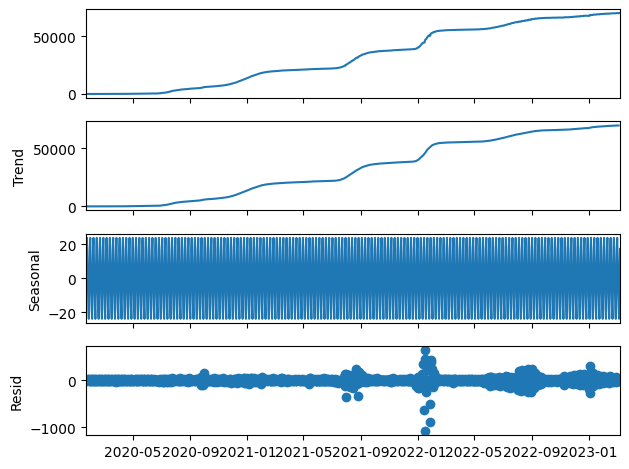

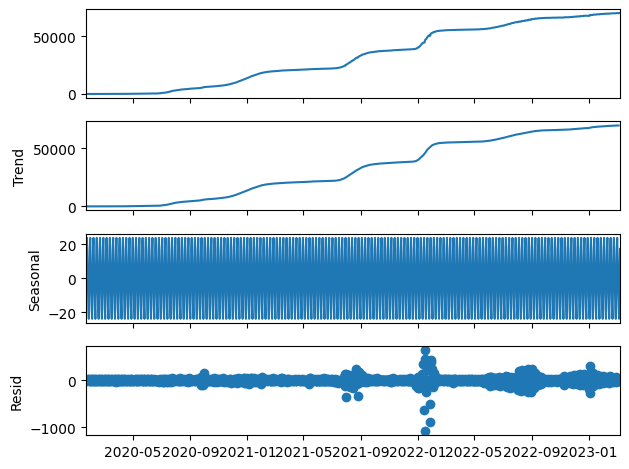

In [6]:
decompose_data = seasonal_decompose(df_1, model="additive")
decompose_data.plot()

In [7]:
# decomposition = seasonal_decompose(df_1['TEMP'], model='additive', period=7)


In [8]:
df_1['cases'] = df_1['cases'] - decompose_data.seasonal
df_1 = df_1.diff(periods=1)
df_1 = df_1.dropna()


In [9]:
df_1.tail()

,cases
time,
2023-03-05,12.239264
2023-03-06,13.699387
2023-03-07,6.650318
2023-03-08,74.695767
2023-03-09,-22.915344


Train and Test Split

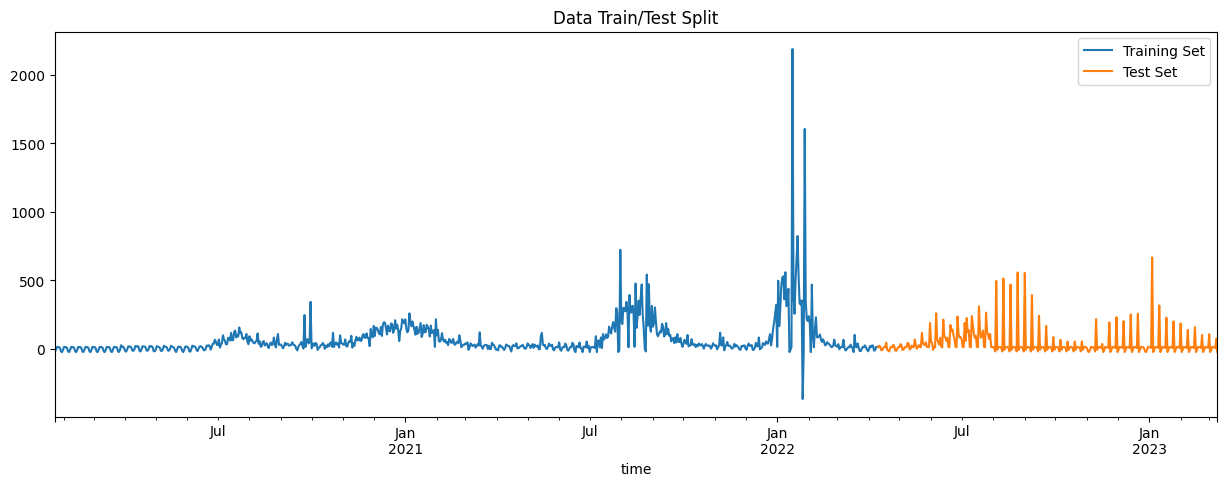

In [10]:

train = df_1.loc[df_1.index < '2022-04-10']
test = df_1.loc[df_1.index >= '2022-04-10']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y , df['date']
    return X, df['date']

In [12]:
X_train , y_train , train_d  = create_features(train, label='cases')
X_test, y_test , test_d = create_features(test, label='cases')

In [13]:
y_train

time
2020-01-23   -22.915344
2020-01-24    -6.507937
2020-01-25    15.138545
2020-01-26    12.239264
2020-01-27    13.699387
                ...    
2022-04-05    24.650318
2022-04-06   -11.304233
2022-04-07   -10.915344
2022-04-08    14.492063
2022-04-09    15.138545
Name: cases, Length: 808, dtype: float64

In [14]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [15]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

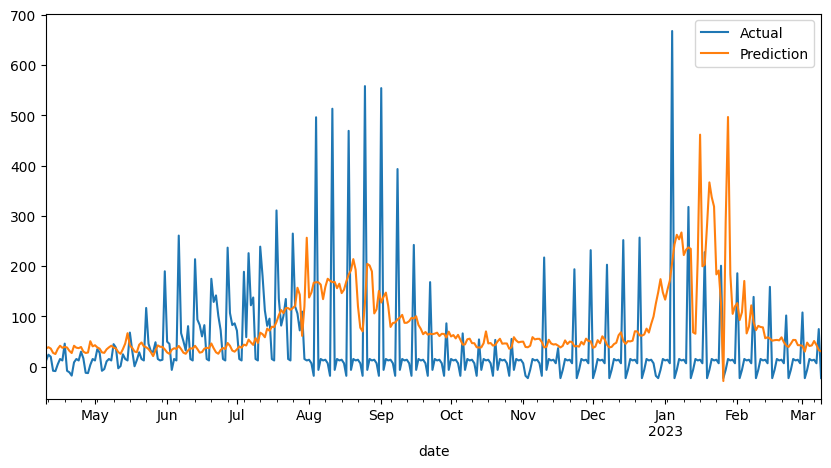

MAE: 85.05221601550453
MSE: 14116.12723315761
MAPE: 6.106974267254349


In [16]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(test_d, y_test, prediction)
evaluate_model(y_test, prediction)

In [17]:
df_confirmed_global

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [75]:
df_total = df_confirmed_global.iloc[:,4:]
#df_total.rename(columns = {'index':'time',1:'cases'}, inplace=True)
# df_total['time'] = pd.to_datetime(df_total['time'], format='%m/%d/%y')
# df_total['cases'] = df_total['cases'].astype(float)
# df_total.set_index('time', inplace=True)
df_total

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,0,0,0,0,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [76]:
df_total = df_total.sum().to_frame().reset_index()
df_total.rename(columns = {'index':'time',0:'cases'}, inplace=True)
df_total['time'] = pd.to_datetime(df_total['time'], format='%m/%d/%y')
df_total['cases'] = df_total['cases'].astype(float)
df_total.set_index('time', inplace=True)

In [64]:
df_total

,cases
time,
2020-01-22,557.0
2020-01-23,657.0
2020-01-24,944.0
2020-01-25,1437.0
2020-01-26,2120.0
...,...
2023-03-05,676024901.0
2023-03-06,676082941.0
2023-03-07,676213378.0


In [66]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x = df_total.index, y = df_total['cases'])])
fig.show()

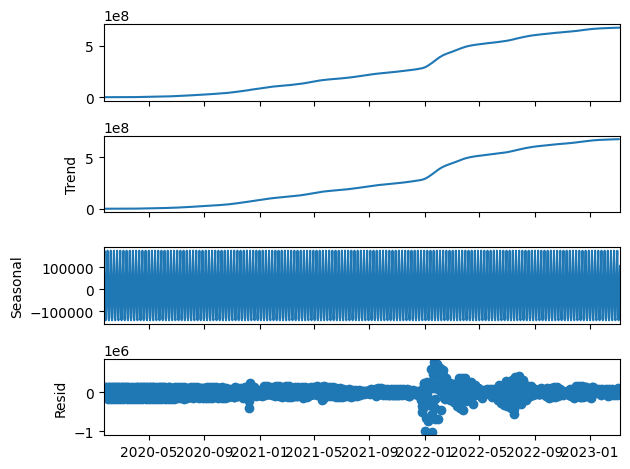

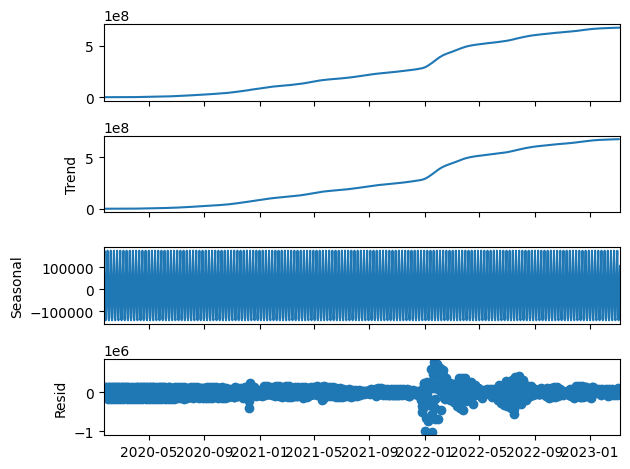

In [67]:
decompose_data = seasonal_decompose(df_total, model="additive")
decompose_data.plot()

In [77]:
#df_total['cases'] = df_total['cases'] - decompose_data.seasonal
df_total = df_total.diff(periods=1)
df_total = df_total.dropna()

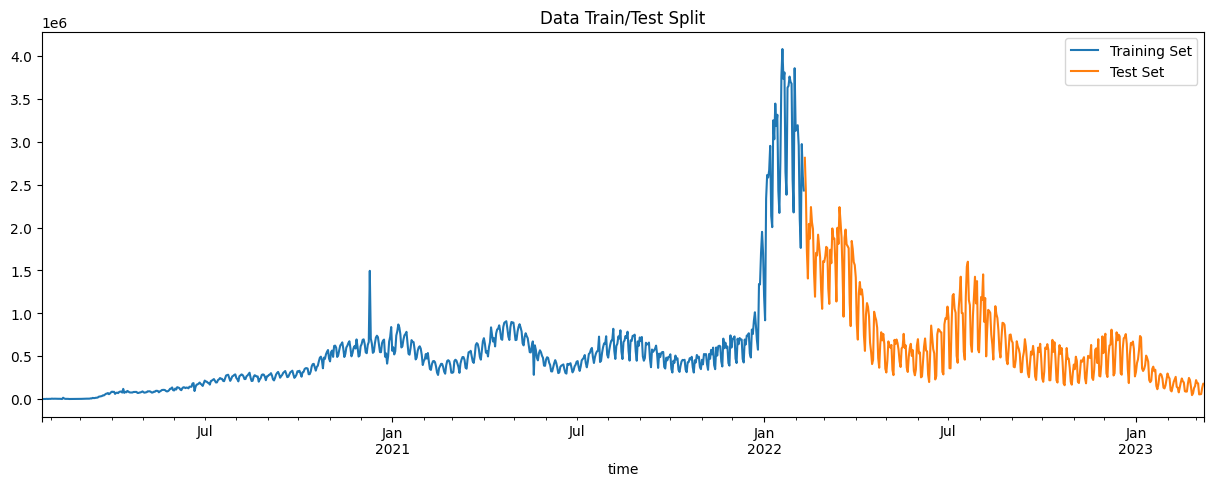

In [79]:
train_total = df_total.loc[df_total.index < '2022-02-10']
test_total = df_total.loc[df_total.index >= '2022-02-10']

fig, ax = plt.subplots(figsize=(15, 5))
train_total.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_total.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [80]:
X_train_t , y_train_t , train_d_t  = create_features(train_total, label='cases')
X_test_t, y_test_t , test_d_t = create_features(test_total, label='cases')

In [81]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train_t, y_train_t)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

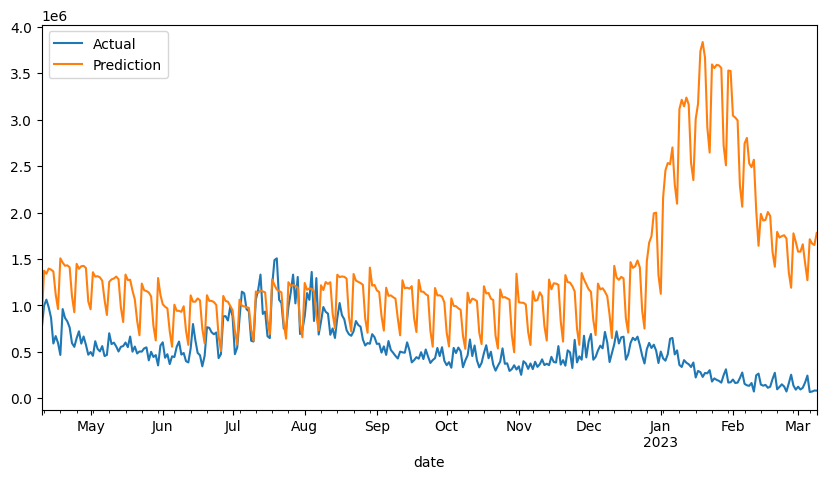

MAE: 826355.3719386598
MSE: 1312864850579.7495
MAPE: 3.196952633366036


In [74]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test_t)
plot_predictions(test_d_t, y_test_t, prediction)
evaluate_model(y_test_t, prediction)